In [1]:
# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
import pandas as pd
from datetime import datetime
import re
import nltk
import json
import numpy as np
from nltk import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from textblob import TextBlob
#import contractions 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import sklearn.tree
import re
%matplotlib inline
import csv
import sklearn
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
sns.set(style="darkgrid")

import gensim
from gensim.models import Phrases, KeyedVectors, Word2Vec
import gensim.downloader

from scipy import stats
from statistics import mean 
from nltk.sentiment import SentimentIntensityAnalyzer
import xgboost as xgb
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
pass

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/simranbhatia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simranbhatia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/simranbhatia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/simranbhatia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/simranbhatia/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Problem Introduction

We have a dataset in JSON format containing information about the user activity in a reddit forum **ROAP**. Our feature set comes from a bunch of user features noted at the time of posting user comments in the forun alogside the titel and text they chose. The response variable is whether the requester received the pizza or not.

### 1. Loading the training data

In [2]:
with open('data/random-acts-of-pizza/train.json') as f:
    train_json_data = json.load(f)

In [3]:
df = pd.io.json.json_normalize(train_json_data) 
df.head()
pass

<ipython-input-3-d0ca947ab42d>:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = pd.io.json.json_normalize(train_json_data)


In [4]:
print('Total data rows in full training set: {}'.format(df.shape[0]))
print('Total data columns in full training set: {}'.format(df.shape[1]))

Total data rows in full training set: 4040
Total data columns in full training set: 32


### 2. Splitting training set into training and validation

As we don't have labeled test set, we have to split existing training data into training and validation set in order to evaluate our model performance. We have already split the train and validation in 90/10 ratio and saved as csv files. We read them directly in memory.

In [5]:
# split data in training and test data
train, val = train_test_split(df, test_size=0.1, random_state=42)

In [6]:
print(train.requester_received_pizza.value_counts())

print(val.requester_received_pizza.value_counts())

False    2746
True      890
Name: requester_received_pizza, dtype: int64
False    300
True     104
Name: requester_received_pizza, dtype: int64


### 3. Extracting relevant columns (present in test data) 

In [7]:
relevant_cols = ['request_title', 'request_text_edit_aware' ,
                 'requester_number_of_posts_on_raop_at_request', 
                'requester_number_of_subreddits_at_request', 
                 'unix_timestamp_of_request', 
                'requester_account_age_in_days_at_request',
                'requester_subreddits_at_request',
                'requester_upvotes_minus_downvotes_at_request', 
                'requester_upvotes_plus_downvotes_at_request']

y = 'requester_received_pizza'

In [8]:
def subset_df(data, y_cols, x_cols):
    return data[[y_cols] + x_cols]

In [9]:
train = subset_df(data=train, y_cols=y, x_cols=relevant_cols)
val = subset_df(data=val, y_cols=y, x_cols=relevant_cols)

### 4. Simple Text and Non-text features (function repository)

In [10]:
# Number of subreddits at request 
def num_subreddit_cuts(data, col, grid, lab):
    return pd.cut(data[col], grid, labels=lab)

In [11]:
def num_subreddit_dummy(data, colname):
    """
    data (pandas dataframe): input data frame
    colname (str): original column name
    """
    return pd.get_dummies(data=data, columns=[colname], drop_first=True)

In [12]:
def num_posts_roap(data, colname, id_colname,th=0):
    """
    data (pandas dataframe): input data frame
    colname (str): original column name
    id_colname (str): identifier for the created feature
    th (int): threshold for creating binary feature
    """
    new_colname = id_colname + '_' +colname
    feat = np.where(data[colname] == th, 0, 1)
    data[new_colname] = feat
    del data[colname]
    return data

In [13]:
def add_request_hour_feature(data, time_col, interval):
    """
    data (pandas dataframe): input data frame
    time_col (str): time indicator column
    interval (int): number of intervals 
    """
    data[time_col] =  pd.to_datetime(data[time_col],unit='s')
    hour_bin_int = pd.cut(data[time_col].dt.hour, interval)
    hour_col_name = time_col + '_' + str(interval)
    data[hour_col_name] = str(hour_bin_int).replace(",","-")
    data = data.drop(time_col, axis=1)
    return pd.get_dummies(data=data, columns=[hour_col_name], drop_first=True)

In [14]:
def simple_token_count(v):
    result = []
    for line in v:
        if line != line:
            result.append(1)
            continue
        result.append(len(word_tokenize(line)))
    return result

In [15]:
def lengths_feature(data):
    return [len(t) for t in data['request_text_edit_aware']]

def num_caps_feature(data):
    return [sum(1 for word in x.split() for c in word if c.isupper()) for x in data['request_text_edit_aware']]

def caps_vs_lengths_feature(data):
    return [sum(1 for word in x.split() for c in word if c.isupper())/
                       len(x) if len(x)>0 else 0 for x in data['request_text_edit_aware']]

def num_unique_words_feature(data):
    return [len(set(w for w in x.split())) for x in data['request_text_edit_aware']]

def num_punctuations_feature(data):
    puncs = '!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`'
    return [sum(x.count(w) for w in puncs) for x in data['request_text_edit_aware']]

def requests_with_url(data):
    url_regex = re.compile(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))")
    return [1 if len([f[0] for f in re.findall(url_regex,str(x))])>0 else 0 for x in data['request_text_edit_aware']]

In [16]:
def find_subreddit_freq_with_word(data, col, word):
    result = []
    for grp_list in data[col]:
        counter = 0
        for grp in grp_list:
            if word.lower() in grp.lower():
                counter += 1
        result.append(counter)
    return result

In [17]:
# stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
# adding some of our own stop words to NLTK's stopword list
stopwords_nltk_en = set(stopwords.words('english') + ['though','pizza', 'request', 'hey', 'hi'])
# create stop word list for punctuation
stopwords_punct = set(punctuation)
# combine the three stopwords lists
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

In [18]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

def preprocess_text_tfid(text):
    # Input: str, i.e. document/sentence
    # Output: str , i.e. list of lemmas
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    # remove email addresses
    text = re.sub('\S+@\S+', '', text)
    # convert contractions to their full form
    #text = contractions.fix(text)
    # remove special characters after lemmatizing words
    processed_list = [re.sub('[^A-Za-z0-9]+', '', word) for word in lemmatize_sent(text)
              # remove words is they're on the stop words list or is a digit
            if word not in stoplist_combined
            and not word.isdigit()]
    # turn list of words into a string to that the output is the same format as the input
    return ' '.join(processed_list) 

def preprocess_text_pmi(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    # remove email addresses
    text = re.sub('\S+@\S+', '', text)
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]

In [19]:
def n_gram_nmf_features(data, data_val, col, n_topic, ngram):
    train_vectorizer = TfidfVectorizer(analyzer = 'word', 
                                   preprocessor = preprocess_text_tfid, 
                                   ngram_range = (ngram,ngram), min_df = 2, max_df = 0.95)

    train_vect = train_vectorizer.fit_transform(data[col])
    val_vect = train_vectorizer.transform(data_val[col])

    train_topic_model = NMF(n_components = n_topic, 
                            alpha = .1, 
                            l1_ratio = 0.5).fit(train_vect)

    train_topic_feat = train_topic_model.transform(train_vect)
    val_topic_feat = train_topic_model.transform(val_vect)
    
    new_colnames = ['nmf_' + str(ngram) + 'gram_f_'+str(i+1) for i in range(train_topic_feat.shape[1])]
    df_train = pd.DataFrame(train_topic_feat, columns=new_colnames)
    df_val = pd.DataFrame(val_topic_feat, columns=new_colnames)
    
    return df_train, df_val

In [20]:
def count_words_per_category(v, out):
    result_true, result_false, result_vocab = {}, {}, {}
    for ind, line in enumerate(v):
        #print(ind)
        #print(out[ind])
        trf_line = preprocess_text_pmi(line) # preprocess and lammatized title text
        for elem in trf_line:
            result_vocab[elem] = result_vocab.get(elem, 0) + 1
            
            if out[ind]:
                result_true[elem] = result_true.get(elem, 0) + 1
            else: 
                result_false[elem] = result_false.get(elem, 0) + 1
    
    return result_true, result_false, result_vocab

def pmi(inclass_freq, total_freq, class_freq, min_count=10):
    """
    inclass_freq (dict): dictionary containing inclass frequency for a given word
    total_freq (dict): dictionary containing total frequency for a given word
    class_freq (float): class prevalence
    min_count (int): minimum frequency for pmi calculation
    """
    pmi = {}
    for word, freq in total_freq.items():
        if freq < min_count:
            continue
        pmi[word] = np.log((inclass_freq.get(word, 0) + 0.001) * 1.0 / (class_freq * freq))
    return pmi

def get_counts(data, text_colname, outcome_colname):
    return count_words_per_category(data[text_colname], 
                                    list(data[outcome_colname]))

def get_top_k_from_dict(d, k):
    return sorted(d.items(), key=lambda kv: kv[1])[-k:]

def get_words(sorted_dict):
    return [w[0] for w in sorted_dict]

def calculate_pmi(data, text_colname, outcome_colname, class_freq_true, top_k):
    count_class_true, count_class_false, count_total = get_counts(data = data, 
                                                         text_colname=text_colname, 
                                                         outcome_colname=outcome_colname) 
    pmi_true = pmi(inclass_freq=count_class_true, 
                   total_freq=count_total, 
                   class_freq=class_freq_true)
    
    pmi_false = pmi(inclass_freq=count_class_false, 
                   total_freq=count_total, 
                   class_freq=1-class_freq_true)
    
    pmi_true_top_k = get_top_k_from_dict(pmi_true, k=top_k)
    pmi_false_top_k = get_top_k_from_dict(pmi_false, k=top_k)
    
    pmi_true_words = get_words(pmi_true_top_k)
    pmi_false_words = get_words(pmi_false_top_k)
    
    return pmi_true_words, pmi_false_words

In [21]:
def get_binary_feature(word, vector, wv):
    result = []
    candidates = set([w[0] for w in wv.most_similar(word, topn=20)] + [word])
    for line in vector:
        if line != line:
            result.append(0)
            continue
        trf_line = preprocess_text_pmi(line)
        if len(candidates.intersection(set(trf_line))) > 0:
            result.append(1)
        else:
            result.append(0)
    return result

def text_feature_addition(word_list, df, colname, id_str, wv):
    for ind, word in enumerate(word_list):
        print(ind, ' : ', word)
        f_name = id_str + word
        feat = get_binary_feature(word, df[colname], wv)
        df[f_name] = feat
    return df

In [22]:
def manual_categories(data, col):
    # understand if the given categories, gratitude or reciprocity is expressed in the raw text
    
    # Categories
    desire = re.compile(r'(friend|party|birthday|boyfriend|girlfriend|date|drinks|drunk|wasted|invite|invited|celebrate|celebrating|game|games|movie|beer|crave|craving)', re.IGNORECASE)
    family = re.compile(r'(husband|wife|family|parent|parents|mother|father|mom|mum|son|dad|daughter)', re.IGNORECASE)
    job = re.compile(r'(job|unemployment|employment|hire|hired|fired|interview|work|paycheck)', re.IGNORECASE)
    money = re.compile(r'(money|bill|bills|rent|bank|account|paycheck|due|broke|bills|deposit|cash|dollar|dollars|bucks|paid|payed|buy|check|spent|financial|poor|loan|credit|budget|day|now| \
        time|week|until|last|month|tonight|today|next|night|when|tomorrow|first|after|while|before|long|hour|Friday|ago|still|due|past|soon|current|years|never|till|yesterday|morning|evening)', re.IGNORECASE)
    student = re.compile(r'(college|student|university|finals|study|studying|class|semester|school|roommate|project|tuition|dorm)', re.IGNORECASE)
    # Gratitude
    gratitude = re.compile(r'(thank|thanks|thankful|appreciate|grateful|gratitude|advance)',re.IGNORECASE)
    # Reciprocity
    reciprocity = re.compile(r'(pay it forward|pay forward|paid it forward|pay the act forward|pay the favor back|paying it forward|pay this forward|pay pizza forward|pay back|pay it back|pay you back|return the favor|return the favour|pay a pizza forward|repay)',re.IGNORECASE)
    
    data['desire_category'] = data[col].apply(lambda x: len(desire.findall(x)))
    data['family_category'] = data[col].apply(lambda x: len(family.findall(x)))
    data['job_category'] = data[col].apply(lambda x: len(job.findall(x)))
    data['money_category'] = data[col].apply(lambda x: len(money.findall(x)))
    data['student_category'] = data[col].apply(lambda x: len(student.findall(x)))
    data['gratitude'] = data[col].apply(lambda x: np.where(len(gratitude.findall(x)) > 0, 1, 0))    
    data['reciprocity'] = data[col].apply(lambda x: np.where(len(reciprocity.findall(x))> 0, 1, 0))
    
    return data

In [23]:
sia = SentimentIntensityAnalyzer()

def basic_sentiment(data, col):
    def is_positive(text):
        if not(text.strip()):
            return 0
        return mean([sia.polarity_scores(sentence)["compound"] for sentence in nltk.sent_tokenize(text)]) > 0 
    
    def total_score(text):
        if not(text.strip()):
            return 0
        return sum([sia.polarity_scores(sentence)["compound"] for sentence in nltk.sent_tokenize(text)])
    
    def avg_score(text):
        if not(text.strip()):
            return 0
        return mean([sia.polarity_scores(sentence)["compound"] for sentence in nltk.sent_tokenize(text)])
    
    pos_bool, tot_scr, avg_scr = [], [], []
    
    for row in range(len(data)):
        text = data.loc[row, col]
        pos_bool.append(is_positive(text))
        tot_scr.append(total_score(text))
        avg_scr.append(avg_score(text))
    
    data.loc[:,'positive_sentiment_bool'] = pos_bool
    data.loc[:,'total_sentiment_score'] = tot_scr
    data.loc[:,'average_sentiment_score'] = avg_scr
    
    return data

In [24]:
# Doc2Vec
def get_signal(model, i):
    try:
        return model[i].any()
    except KeyError:
        return False

def output_df(trained_model, is_training=True, data=None):
    result = []
    if is_training:
        counter = 0
        while get_signal(trained_model, counter):
            result.append(list(trained_model[counter]))
            counter+=1
    else:
        result = data
    
    col_names = ['d2v_'+str(i+1) for i in range(trained_model.vector_size)]
    return pd.DataFrame(result, columns=col_names)

def create_corpus(data, col, only_tokens=False):
    for row in range(len(data)):
        line = data.loc[row, col]
        tokens = gensim.utils.simple_preprocess(line, deacc=True)
        if only_tokens:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [row])
            
def train_doc2_vec(data, col):
    corpus = list(create_corpus(data, col))
    model = gensim.models.doc2vec.Doc2Vec(vector_size=25, min_count=2, epochs=50)
    model.build_vocab(corpus)
    model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)
    return model

def get_training_vectors(trained_model):
    return output_df(trained_model)

def infer_vectors(data, col, trained_model):
    corpus = list(create_corpus(data, col, only_tokens=True))
    vocab = list(trained_model.wv.vocab.keys())
    result = []
    for row in corpus:
        input_text = [t for t in row if t in vocab]
        result.append(trained_model.infer_vector(input_text))
    return output_df(trained_model, is_training=False, data=result)

### 5. Feature addition

In [25]:
t1 = num_subreddit_cuts(data = train, 
                        col = 'requester_number_of_subreddits_at_request', 
                        grid = [-np.inf, 0, 5, 10, 50, 100, np.inf], 
                        lab = ['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+'])

v1 = num_subreddit_cuts(data = val, 
                        col = 'requester_number_of_subreddits_at_request', 
                        grid = [-np.inf, 0, 5, 10, 50, 100, np.inf], 
                        lab = ['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+'])

train.loc[:,'num_subreddits_req'] = t1
val.loc[:,'num_subreddits_req'] = v1

train = num_subreddit_dummy(data = train, colname= 'num_subreddits_req')
val = num_subreddit_dummy(data = val, colname= 'num_subreddits_req')

In [26]:
train = num_posts_roap(data=train, colname='requester_number_of_posts_on_raop_at_request', id_colname='binary')
val = num_posts_roap(data=val, colname='requester_number_of_posts_on_raop_at_request', id_colname='binary')

In [27]:
train = add_request_hour_feature(data = train, time_col='unix_timestamp_of_request', interval=4)
val = add_request_hour_feature(data = val, time_col='unix_timestamp_of_request', interval=4)

In [28]:
train.loc[:,'title_length'] = simple_token_count(train.request_title)
train.loc[:,'text_length'] = simple_token_count(train.request_text_edit_aware)
val.loc[:,'title_length'] = simple_token_count(val.request_title)
val.loc[:,'text_length'] = simple_token_count(val.request_text_edit_aware)

In [29]:
train.loc[:,'active_random_subr'] = find_subreddit_freq_with_word(data=train, col='requester_subreddits_at_request', word='random')
train.loc[:,'active_raop_subr'] = find_subreddit_freq_with_word(data=train, col='requester_subreddits_at_request', word='Random_Acts_Of_Pizza')
train.loc[:,'active_food_subr'] = find_subreddit_freq_with_word(data=train, col='requester_subreddits_at_request', word='food')

val.loc[:,'active_random_subr'] = find_subreddit_freq_with_word(data=val, col='requester_subreddits_at_request', word='random')
val.loc[:,'active_raop_subr'] = find_subreddit_freq_with_word(data=val, col='requester_subreddits_at_request', word='Random_Acts_Of_Pizza')
val.loc[:,'active_food_subr'] = find_subreddit_freq_with_word(data=val, col='requester_subreddits_at_request', word='food')

In [30]:
train.loc[:,'lengths_text'] = lengths_feature(data=train)
train.loc[:,'num_caps_text'] = num_caps_feature(data=train)
train.loc[:,'capsvslen_text'] = caps_vs_lengths_feature(data=train)
train.loc[:,'num_unique_words_text'] = num_unique_words_feature(data=train)
train.loc[:,'num_puncs_text'] = num_punctuations_feature(data=train)
train.loc[:,'num_req_w_url_text'] = requests_with_url(data=train)

val.loc[:,'lengths_text'] = lengths_feature(data=val)
val.loc[:,'num_caps_text'] = num_caps_feature(data=val)
val.loc[:,'capsvslen_text'] = caps_vs_lengths_feature(data=val)
val.loc[:,'num_unique_words_text'] = num_unique_words_feature(data=val)
val.loc[:,'num_puncs_text'] = num_punctuations_feature(data=val)
val.loc[:,'num_req_w_url_text'] = requests_with_url(data=val)

In [31]:
bigram_nmf_train, bigram_nmf_val = n_gram_nmf_features(data=train, data_val=val, 
                                                       col='request_text_edit_aware', n_topic=5, ngram=2)

unigram_nmf_train, unigram_nmf_val = n_gram_nmf_features(data=train, data_val=val, 
                                                       col='request_text_edit_aware', n_topic=10, ngram=1)

In [32]:
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)
train = pd.concat([train, bigram_nmf_train, unigram_nmf_train], axis=1)
val = pd.concat([val, bigram_nmf_val, unigram_nmf_val], axis=1)

In [33]:
train = manual_categories(data=train, col='request_text_edit_aware')
val = manual_categories(data=val, col='request_text_edit_aware')

In [34]:
train = basic_sentiment(data=train, col='request_text_edit_aware')
val = basic_sentiment(data=val, col='request_text_edit_aware')

In [35]:
# Doc2Vec 
m = train_doc2_vec(train, 'request_text_edit_aware')
d2v_train = get_training_vectors(m)
d2v_val = infer_vectors(val, 'request_text_edit_aware', m)

train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

train = pd.concat([train, d2v_train], axis=1)
val = pd.concat([val, d2v_val], axis=1)

In [36]:
w_vect = gensim.downloader.load('glove-twitter-50')

In [37]:
true_class_pmi_words_title, false_class_pmi_words_title = calculate_pmi(data = train, 
                                                                        text_colname='request_title', 
                                                                        outcome_colname='requester_received_pizza', 
                                                                        class_freq_true=0.24505, 
                                                                        top_k=10)

true_class_pmi_words_text, false_class_pmi_words_text = calculate_pmi(data = train, 
                                                                      text_colname='request_text_edit_aware', 
                                                                      outcome_colname='requester_received_pizza', 
                                                                      class_freq_true=0.24505, 
                                                                      top_k=10)

In [38]:
train = text_feature_addition(word_list=false_class_pmi_words_text, 
                                    df=train, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_false_')

train = text_feature_addition(word_list=true_class_pmi_words_text, 
                                    df=train, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_true_')

train = text_feature_addition(word_list=false_class_pmi_words_title, 
                                    df=train, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_false_')

train = text_feature_addition(word_list=true_class_pmi_words_title, 
                                    df=train, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_true_')

0  :  english
1  :  ta
2  :  animal
3  :  ga
4  :  dead
5  :  essay
6  :  bc
7  :  tide
8  :  needless
9  :  fancy
0  :  individual
1  :  puppy
2  :  fry
3  :  sum
4  :  admit
5  :  kidney
6  :  lawyer
7  :  collect
8  :  package
9  :  bonus
0  :  people
1  :  ct
2  :  jersey
3  :  order
4  :  noodle
5  :  enjoy
6  :  na
7  :  class
8  :  pepperoni
9  :  wan
0  :  fail
1  :  smile
2  :  anniversary
3  :  nj
4  :  father
5  :  baby
6  :  daughter
7  :  tucson
8  :  happy
9  :  lot


In [39]:
val = text_feature_addition(word_list=false_class_pmi_words_text, 
                                    df=val, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_false_')

val = text_feature_addition(word_list=true_class_pmi_words_text, 
                                    df=val, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_true_')

val = text_feature_addition(word_list=false_class_pmi_words_title, 
                                    df=val, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_false_')

val = text_feature_addition(word_list=true_class_pmi_words_title, 
                                    df=val, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_true_')

0  :  english
1  :  ta
2  :  animal
3  :  ga
4  :  dead
5  :  essay
6  :  bc
7  :  tide
8  :  needless
9  :  fancy
0  :  individual
1  :  puppy
2  :  fry
3  :  sum
4  :  admit
5  :  kidney
6  :  lawyer
7  :  collect
8  :  package
9  :  bonus
0  :  people
1  :  ct
2  :  jersey
3  :  order
4  :  noodle
5  :  enjoy
6  :  na
7  :  class
8  :  pepperoni
9  :  wan
0  :  fail
1  :  smile
2  :  anniversary
3  :  nj
4  :  father
5  :  baby
6  :  daughter
7  :  tucson
8  :  happy
9  :  lot


In [40]:
exclude_cols = ['requester_received_pizza', 'request_title', 
                'request_text_edit_aware', 'requester_subreddits_at_request']
Xcols=[c for c in train.columns if c not in exclude_cols]

In [41]:
def get_param_grids():
    param_grids = {}
    param_grids['svm'] = {
        #'kernel': ['rbf', 'poly', 'sigmoid'],
        'C': [0.1, 1, 100] ,
        'gamma': [0.0001, 0.001, 0.1, 1, 5]}

    param_grids['knn'] = {
        'n_neighbors':[5,6,7,8,9,10],
        'leaf_size':[1,2,3,5],
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree','kd_tree','brute'],
        'n_jobs':[-1]}

    param_grids['rf'] = {
        'n_estimators': [int(x) for x in np.linspace(200, 1000, 5)],
        'max_depth': [int(x) for x in np.linspace(1, 10, 1)],
        'max_features': ['auto', 'log2', 8, 10, 15, 20],
        'min_samples_split': [int(x) for x in np.linspace(4, 10, 7)],
        'bootstrap': [True, False], 
        'class_weight': [None, 'balanced', 'balanced_subsample']}

    param_grids['et'] = {
        'n_estimators': range(50,126,25),
        'max_features': range(50,401,50),
        'min_samples_leaf': range(20,50,5),
        'min_samples_split': range(15,36,5)}

    param_grids['xgb'] = {
        'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        'max_depth'        : [3, 4, 5, 6, 8, 10, 12, 15],
        'min_child_weight' : [1, 3, 5, 7],
        'gamma'            : [0.0, 0.1, 0.2 , 0.3, 0.4],
        'colsample_bytree' : [0.3, 0.4, 0.5 , 0.7]}

    param_grids['ada'] = {
        'n_estimators': [10, 50, 100, 500],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]}

    param_grids['gbm'] = {
        'n_estimators': [10, 100, 1000],
        'learning_rate': [0.001, 0.01, 0.1],
        'subsample': [0.5, 0.7, 1.0],
        'max_depth': [3, 7, 9]
    }

    param_grids['lr'] = {
        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'penalty': ['l2'],
        'C': [100, 10, 1.0, 0.1, 0.01]}

    param_grids['nb'] = {
        'var_smoothing': np.logspace(0,-9, num=10)}

    param_grids['nn'] = {
        'hidden_layer_sizes': [(10,30,10),(20,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive']}

    param_grids['bag'] = {'n_estimators': [10, 100, 1000]}
    
    return param_grids

### 6. Model Hyperparameter tuning

In [42]:
def model_eval(model, model_class, X, y, param_grids):
    
    cv = GridSearchCV(model, param_grid=param_grids, cv=5, scoring='roc_auc', n_jobs=-1, verbose=3)

    cv.fit(X,y)
    
    print(cv.best_params_)
    return cv.best_estimator_

### 7. Building Model

In [63]:
def get_model_classes():
    model_classes = {}
    model_classes['knn'] = KNeighborsClassifier()
    model_classes['svm'] = sklearn.svm.SVC(probability=True)
    model_classes['rf'] = RandomForestClassifier()
    model_classes['et'] = ExtraTreesClassifier()
    model_classes['xgb'] = xgb.XGBClassifier(random_state=1)
    model_classes['ada'] = AdaBoostClassifier(random_state=1)
    model_classes['gbm'] = GradientBoostingClassifier(random_state=1)
    model_classes['lr'] = LogisticRegression()
    model_classes['nb'] = GaussianNB()
    model_classes['nn'] = MLPClassifier()
    model_classes['bag'] = BaggingClassifier()
    return model_classes

In [64]:
def build_model(X,y, model_class='svm'):
    for col in X:
        if(X[col].dtype=='uint8'):
            X[col] = np.int8(X[col])
        if(X[col].dtype=='object'):
            X[col] = pd.to_numeric(X[col])
    return model_eval(get_model_classes()[model_class], model_class, X, y, get_param_grids()[model_class])

In [65]:
def models_to_include(X,y,model_types_to_include):
    models = []
    for mt in model_types_to_include:
        models.append(build_model(X,y,mt))
    return models

In [66]:
models = models_to_include(train[Xcols], train[y],['svm','knn','rf','et','xgb','ada','gbm','lr','nb','nn','bag'])

Fitting 5 folds for each of 15 candidates, totalling 75 fits


<ipython-input-64-69c554928470>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = np.int8(X[col])
<ipython-input-64-69c554928470>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col])
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.1min finished


{'C': 0.1, 'gamma': 0.0001}
Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


{'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 10, 'weights': 'distance'}
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 5384 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 6248 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed: 26.0min finished


{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 6, 'n_estimators': 400}
Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3944 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  3.5min finished


{'max_features': 50, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 50}
Fitting 5 folds for each of 3840 candidates, totalling 19200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done 5384 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done 6248 tasks      | elapsed: 51.4min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | 

[03:09:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.7s finished


{'learning_rate': 0.01, 'n_estimators': 500}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 15.3min finished


{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   16.9s finished
/Users/simranbhatia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s


{'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


{'var_smoothing': 1e-09}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   35.8s finished


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    1.5s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   13.1s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished


{'n_estimators': 1000}


### 8. Ensemble

#### Helper Functions

In [67]:
def stackX(models, X):
    stackX = None
    for model in models:
        # make prediction
        yhat = model.predict(X)
        # stack predictions into [predictions, rows, members]
        if stackX is None:
            stackX = yhat
        else:
            stackX = np.vstack((stackX, yhat))
    # flatten predictions to [rows, members x predictions]
    stackX = np.transpose(stackX)#stackX.reshape((stackX.shape[1], stackX.shape[1]*stackX.shape[0]))
    return stackX

In [122]:
def build_ensemble(trainX,trainY,evaluateX,evaluateY,models):
    
    for col in evaluateX:
        if(evaluateX[col].dtype=='uint8'):
            evaluateX[col] = np.int8(evaluateX[col])
        if(evaluateX[col].dtype=='object'):
            evaluateX[col] = pd.to_numeric(evaluateX[col])
            
    stack = stackX(models, evaluateX)
    # fit model on the stacked train X
    model_on_stackedX = model_eval(get_model_classes()['nn'], 'nn', stack, val[y], get_param_grids()['nn'])
    model_on_stackedX.fit(stack, evaluateY)
    stacked_ensemble_pred = model_on_stackedX.predict(stack)
    print(classification_report(y_true=evaluateY, y_pred=stacked_ensemble_pred))
    
    # plot the roc curve for each model (except final model)
    for model in models:
        predict_proba = model.predict_proba(evaluateX)[:,1]
        # calculate roc curves
        model_fpr, model_tpr, model_threshold = roc_curve(evaluateY, predict_proba)
        # plot the roc curve for the model
        plt.plot(model_fpr, model_tpr, linestyle='--', label=model)
    
    # plot the roc curve for 
    no_skill = 0.24505
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    
    # plot the roc curve for the ensemble model
    final_predict_proba =  model_on_stackedX.predict_proba(stack)[:,1]
    # calculate roc curves
    final_model_fpr, final_model_tpr, final_model_threshold = roc_curve(evaluateY, final_predict_proba)
    # convert to f score
    fscore = (2 * final_model_fpr * final_model_tpr) / (final_model_tpr + final_model_fpr)
    # locate the index of the largest f score
    ix = np.nanargmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (final_model_threshold[ix], fscore[ix]))
    
    # plot the roc curve for the model
    plt.plot(final_model_fpr, final_model_tpr, marker='.', label=model_on_stackedX, color='black')
    
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    fontP = FontProperties()
    fontP.set_size('xx-small')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
    
    return model_on_stackedX

<ipython-input-122-6d69e98d22a3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluateX[col] = np.int8(evaluateX[col])
<ipython-input-122-6d69e98d22a3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluateX[col] = pd.to_numeric(evaluateX[col])


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.9s finished


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'adam'}


/Users/simranbhatia/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.74      1.00      0.85       300
        True       0.00      0.00      0.00       104

    accuracy                           0.74       404
   macro avg       0.37      0.50      0.43       404
weighted avg       0.55      0.74      0.63       404



<ipython-input-122-6d69e98d22a3>:33: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * final_model_fpr * final_model_tpr) / (final_model_tpr + final_model_fpr)


Best Threshold=0.174379, F-Score=1.000


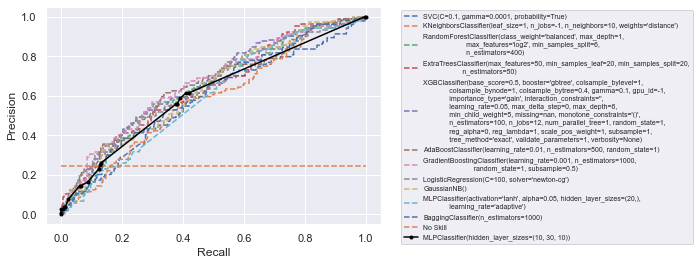

In [123]:
final_ensemble_model = build_ensemble(train[Xcols], train[y], val[Xcols], val[y], models)

### 9. Prediction

In [133]:
with open('data/random-acts-of-pizza/test.json') as f:
    test_json_data = json.load(f)
    
test_df = pd.io.json.json_normalize(test_json_data) 

<ipython-input-133-71b9ffeaac94>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  test_df = pd.io.json.json_normalize(test_json_data)


In [134]:
# conduct same transformations on test data, as on training & val from above
test1 = num_subreddit_cuts(data = test_df, 
                        col = 'requester_number_of_subreddits_at_request', 
                        grid = [-np.inf, 0, 5, 10, 50, 100, np.inf], 
                        lab = ['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+'])
test_df.loc[:,'num_subreddits_req'] = test1
test_df = num_subreddit_dummy(data = test_df, colname= 'num_subreddits_req')

test_df = num_posts_roap(data=test_df, colname='requester_number_of_posts_on_raop_at_request', id_colname='binary')

test_df = add_request_hour_feature(data = test_df, time_col='unix_timestamp_of_request', interval=4)
test_df.loc[:,'title_length'] = simple_token_count(test_df.request_title)
test_df.loc[:,'text_length'] = simple_token_count(test_df.request_text_edit_aware)

test_df.loc[:,'active_random_subr'] = find_subreddit_freq_with_word(data=test_df, 
                                                                    col='requester_subreddits_at_request', 
                                                                    word='random')
test_df.loc[:,'active_raop_subr'] = find_subreddit_freq_with_word(data=test_df, 
                                                                  col='requester_subreddits_at_request', 
                                                                  word='Random_Acts_Of_Pizza')
test_df.loc[:,'active_food_subr'] = find_subreddit_freq_with_word(data=test_df, 
                                                                  col='requester_subreddits_at_request', 
                                                                  word='food')

test_df.loc[:,'lengths_text'] = lengths_feature(data=test_df)
test_df.loc[:,'num_caps_text'] = num_caps_feature(data=test_df)
test_df.loc[:,'capsvslen_text'] = caps_vs_lengths_feature(data=test_df)
test_df.loc[:,'num_unique_words_text'] = num_unique_words_feature(data=test_df)
test_df.loc[:,'num_puncs_text'] = num_punctuations_feature(data=test_df)
test_df.loc[:,'num_req_w_url_text'] = requests_with_url(data=test_df)

bigram_nmf_train, bigram_nmf_test = n_gram_nmf_features(data=train, data_val=test_df, 
                                                       col='request_text_edit_aware', n_topic=5, ngram=2)

unigram_nmf_train, unigram_nmf_test = n_gram_nmf_features(data=train, data_val=test_df, 
                                                       col='request_text_edit_aware', n_topic=10, ngram=1)

test_df.reset_index(inplace=True, drop=True)
test_df = pd.concat([test_df, bigram_nmf_test, unigram_nmf_test], axis=1)

test_df = manual_categories(data=test_df, col='request_text_edit_aware')
test_df = basic_sentiment(data=test_df, col='request_text_edit_aware')

d2v_test = infer_vectors(test_df, 'request_text_edit_aware', m)

test_df.reset_index(inplace=True, drop=True)

test_df = pd.concat([test_df, d2v_test], axis=1)

test_df = text_feature_addition(word_list=false_class_pmi_words_text, 
                                    df=test_df, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_false_')

test_df = text_feature_addition(word_list=true_class_pmi_words_text, 
                                    df=test_df, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_true_')

test_df = text_feature_addition(word_list=false_class_pmi_words_title, 
                                    df=test_df, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_false_')

test_df = text_feature_addition(word_list=true_class_pmi_words_title, 
                                    df=test_df, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_true_')



0  :  english
1  :  ta
2  :  animal
3  :  ga
4  :  dead
5  :  essay
6  :  bc
7  :  tide
8  :  needless
9  :  fancy
0  :  individual
1  :  puppy
2  :  fry
3  :  sum
4  :  admit
5  :  kidney
6  :  lawyer
7  :  collect
8  :  package
9  :  bonus
0  :  people
1  :  ct
2  :  jersey
3  :  order
4  :  noodle
5  :  enjoy
6  :  na
7  :  class
8  :  pepperoni
9  :  wan
0  :  fail
1  :  smile
2  :  anniversary
3  :  nj
4  :  father
5  :  baby
6  :  daughter
7  :  tucson
8  :  happy
9  :  lot


In [142]:
def predict_test(final_model, test):
    for col in test:
        if(test[col].dtype=='uint8'):
            test[col] = np.int8(test[col])
        if(test[col].dtype=='object'):
            test[col] = pd.to_numeric(test[col])
            
    stack = stackX(models, test)
    prediction_test = final_ensemble_model.predict(stack).astype(int)
    return prediction_test

In [146]:
predictions_final = predict_test(final_ensemble_model, test_df[Xcols])
predictions_dataset = pd.DataFrame({'request_id': test_df['request_id'], 
                                    'requester_received_pizza': predictions_final}, 
                                   columns=['request_id', 'requester_received_pizza'])
predictions_dataset.to_csv("kaggle_submission_predictions.csv")

<ipython-input-142-30179d1d78e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = np.int8(test[col])
<ipython-input-142-30179d1d78e9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = pd.to_numeric(test[col])


## Error analysis

In [ ]:
base_data = val[['requester_received_pizza', 'request_title', 'request_text_edit_aware']]

In [ ]:
base_data.loc[:,'prediction'] = prediction_probs

In [ ]:
base_data['predicted_lable'] = prediction_probs>=0.1551

In [ ]:
base_data.head()

In [ ]:
pd.crosstab(base_data.requester_received_pizza, base_data.predicted_lable)

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
base_data[(base_data['requester_received_pizza']) & ~(base_data['predicted_lable'])]

In [ ]:
base_data[(~base_data['requester_received_pizza']) & (base_data['predicted_lable'])].sort_values(by='prediction', 
                                                                                                 ascending=False).head(20)

In [ ]:
base_data[(base_data['requester_received_pizza']) & (base_data['predicted_lable'])].sort_values(by='prediction', 
                                                                                                 ascending=False).head(20)